# 참조

In [ ]:
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import data
import urllib.request

# 0. 특징 검출기 개요


## 1. 특징 검출기 (Feature Detector)

* 특징 검출기는 이미지에서 중요한 지점, 즉 `"특징"을 찾아내는 알고리즘`입니다.

* 특징은 이미지의 특정 부분이 독특하고 다른 부분과 구분될 수 있는 지점을 의미합니다.

## 2. 디스크립터 (Descriptor)

* 디스크립터는 `검출된 특징점 주변의 이미지를 설명하는 벡터`입니다.

* 특징점의 주변 정보를 벡터 형태로 변환하여 `다른 이미지와의 매칭에 사용`됩니다.

* 디스크립터는 각 특징점을 표현하기 때문에, 이를 통해 이미지 간의 유사성을 비교할 수 있습니다.

## 3. 매칭 (Matching)

* 매칭 과정은 `두 이미지의 디스크립터를 비교하여 같은 특징점을 찾는 과정`입니다.

* 이미지 간의 유사성을 평가하고, 동일한 장면이나 객체를 찾는 데 사용됩니다.


## 4. KeyPoint 클래스

* `KeyPoint 클래스`는 이미지의 특징점을 표현하는 데이터 구조입니다.

* KeyPoint 클래스 멤버

  - pt: 특징점의 좌표 (x, y).

  - size: 특징점의 직경.

  - angle: 특징점의 방향 (0~360도).

  - response: 특징점의 응답 값 (강도).

  - octave: 특징점이 속한 이미지 피라미드의 옥타브.

  - class_id: 특징점을 그룹화하기 위한 식별자.


## 5. 전체 과정

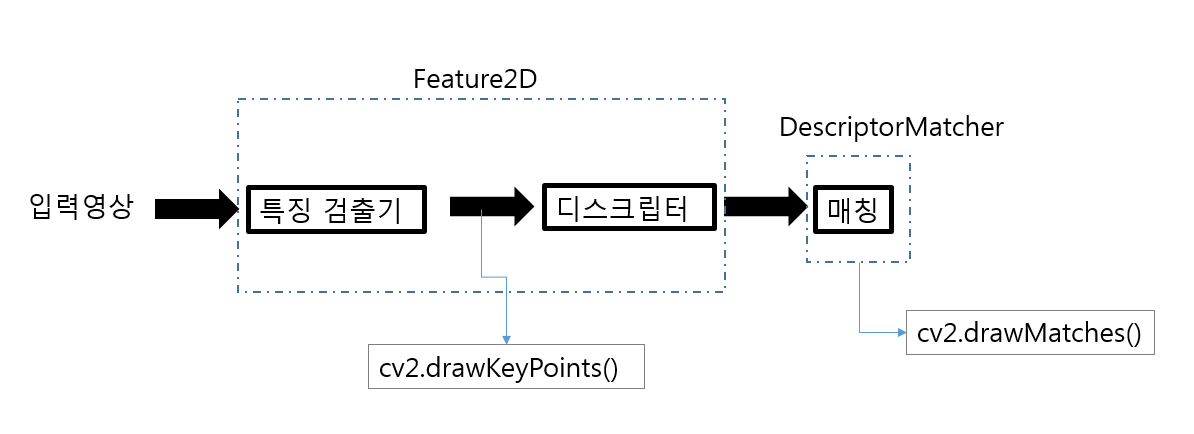
[그림 1] 특징 검출기, 디스크립터, 매칭 과정

1. 특징 검출기를 사용하여 이미지에서 `특징점을 검출`합니다.

2. 각 특징점 주변의 `디스크립터를 생성`합니다.

3. 두 이미지의 `디스크립터를 매칭`하여 같은 특징점을 찾습니다.

4. 매칭된 특징점을 이용하여 이미지 간의 변환(예: 이동, 회전, 크기 조정)을 계산하고, 이를 통해 이미지 정합, 물체 인식, 3D 재구성 등을 수행할 수 있습니다.

## 6. 주요 특징점 검출기와 디스크립트 클래스 구조

* 특징 검출기는 `create()`로 객체 생성

* 특징은 `Feature2D.detect()` 메서드로 검출.

* 디스크립터는 `Feature2D.compute()` 메서드로 게산.

* 특징 검출, 디스크립터 계산이 가능한 클래스에서는 `Feature2D.detectAndCompute()`로 특징 검출, 디스크립터 계산 동시에 가능.

## 7.  응용 분야

이미지 분석, 로봇 비전, 자율주행 등 다양한 응용 분야에서 중요한 역할을 합니다.

# 1. FastFeatureDetector 특징 검출

## FAST 특징 검출기

* FAST(Features from Accelerated Segment Test) 특징 검출기는 효율적이고 신속한 코너 검출 알고리즘으로, 주로 이미지의 작은 패치를 검사하여 코너인지 여부를 판별합니다.

## FAST 특징 검출기의 동작 원리

### 세그먼트 테스트 기준

1. 코너 후보 픽셀 $p$ 주위에 있는 원형 고리의 16개 픽셀을 검사합니다.

2. `원형 고리의 16개 픽셀 중 1, 5, 9, 13번 위치(동서남북 방향)의 픽셀을 먼저 검사`합니다.

3. 이 중 최소 세 개가 후보 픽셀 $I_p$보다 밝거나 ($I_p + t$ 초과) 어두운 ($I_p - t$ 미만) 경우 $p$를 코너 후보로 간주합니다.

4. 첫 번째 테스트를 통과한 픽셀에 대해서만 원형 고리의 나머지 픽셀을 검사하여, 12개 이상의 연속적인 픽셀이 $I_p$보다 밝거나 어두운지를 확인합니다. 이를 통해 최종적으로 $p$가 코너인지 판단합니다.

## FAST 특징 검출기의 효율적인 계산 방법

### Trajkovic and Hedley의 `응답의 상한 추정을 이용한 빠른 처리 방식` 차용

* Trajkovic와 Hedley는 원형 고리에서 중심 픽셀 $f_C$와 원형 고리의 두 끝 픽셀 $f_P$ 및 $f_{P'}$의 차이를 계산하여 코너를 검출하는 방법을 제안했습니다.

$$
C = \min_P \left[ (f_P - f_C)^2 + (f_{P'} - f_C)^2 \right]
$$

* `minimum response function` 는 원형 고리의 모든 가능한 방향에서 계산된 값을 평가하여 **가장 작은 값이 특정 임계값보다 크면 해당 위치가 코너로 간주**됩니다.

* 응답 값을 계산할 때, 모든 방향에서의 세부적인 검색을 수행하지 않고, `몇몇 중요한 방향에서의 측정값을 사용하여 응답의 최대값(상한)을 예측`할 수 있습니다.

* `추정된 최대값(상한)이 너무 낮으면 해당 위치를 코너 후보에서 제외`시켜 계산을 효율적으로 만듭니다.

## FAST 코너 검출 알고리즘의 단점

세그먼트 테스트 기준을 사용하여 코너를 측정할 때 발생하는 4가지 주요 단점

1. `n 값이 12보다 작은 경우 코너를 정확하게 검출하기 어렵다`는 것을 의미합니다.

2. `코너나 특징의 형태가 특정한 방식으로 분포되어 있을 것이라는 전제`에서 비롯됩니다. (실제 이미지의 다양한 코너 형태나 특징의 분포와 맞지 않을 수 있습니다.)

3. 먼저 검사한 4개 지점의 정보가 후처리에 사용되지 않고 버려집니다.

4. 서로 가까운 위치에서 여러 코너가 검출되어, `중복 검출 문제`가 발생할 수 있습니다.

## 비최대 억제(V)를 사용한 단점 보완

* `중복 검출 문제`를 보완하기 위해 비최대 억제(Non-Maximal Suppression)를 사용하여 코너 검출의 정확성을 높입니다.

$$
\begin{equation}
    V = \max \left( \sum_{x \in S_{\text{bright}}} |I_{p \rightarrow x} - I_p| - t, \sum_{x \in S_{\text{dark}}} |I_p - I_{p \rightarrow x}| - t \right)
\end{equation}
$$

* 중심 픽셀과 주변 픽셀의 밝기 차이를 통해 코너의 강도$(V$)를 측정합니다.

* `강도$(V$) 맵에서 지역 최대값 픽셀을 찾아 출력`합니다.



### OpenCV를 이용한 FAST 특징 검출

1. Fast 특징 검출기 객체 생성 `create()`

2. 특징 검출 `detect()` -> KeyPoints 반환

3. 특징 점 시각화 `drawKeyPoints()` -> outImage 반환

len(kp)= 268


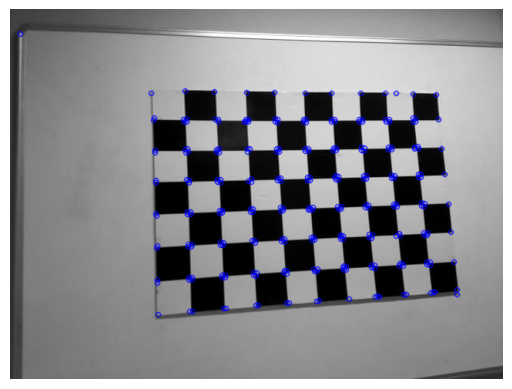

In [ ]:
src = cv2.imread('/content/drive/MyDrive/Image/chessboard.jpg의 사본')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

#1 FastFestureDetector 객체 생성
fastF = cv2.FastFeatureDetector.create(threshold = 30)

#2 특징점 리스트 keypoints를 검출
kp = fastF.detect(gray, None)

dst = cv2.drawKeypoints(gray, kp, None, color = (0,0,255))

print('len(kp)=' , len(kp))

plt.imshow(dst)
plt.axis('off')
plt.show()


len(kp2)= 1466


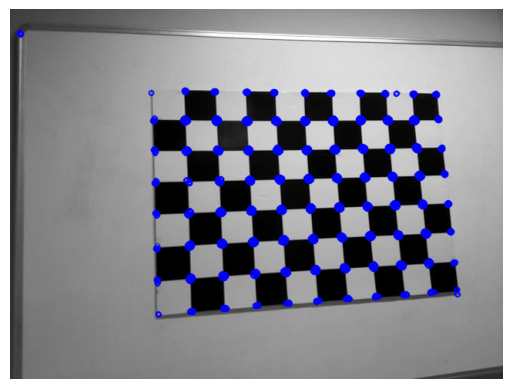

In [ ]:
#3 지역 극값억제를 하지 않은 경우
fastF.setNonmaxSuppression(False)
kp2 = fastF.detect(gray, None)
dst2 = cv2.drawKeypoints(gray, kp2, None, color = (0,0,255))
print('len(kp2)=' , len(kp2))

plt.imshow(dst2)
plt.axis('off')
plt.show()

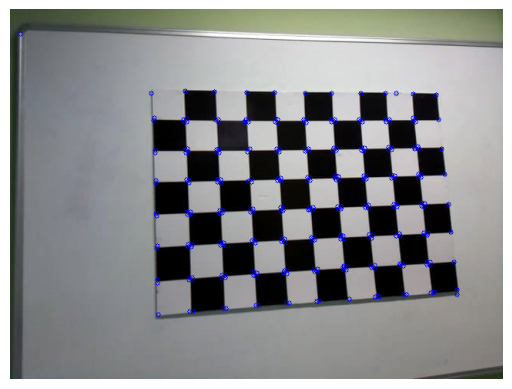

In [ ]:
#4 특징점을 좌표 리스트로 변환.
dst3 = src.copy()
points = cv2.KeyPoint_convert(kp).astype(np.int32)

for cx, cy in points:
  cv2.circle(dst3, (cx,cy), 3, (0,0,255), 1)

plt.imshow(dst3)
plt.axis('off')
plt.show()

### sorted 함수를 이용하여 반응값 기준으로 정렬하여 표시하기

len(kp)= 268


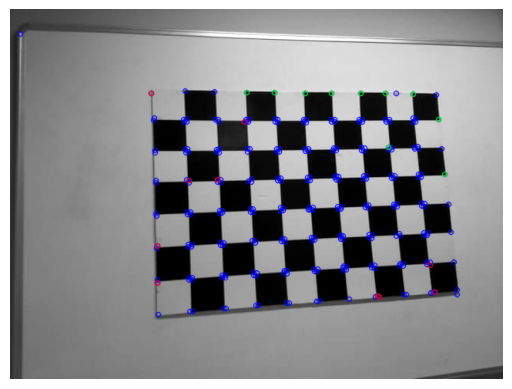

In [ ]:
src = cv2.imread('/content/drive/MyDrive/Image/chessboard.jpg의 사본')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

#1 FastFestureDetector 객체 생성
fastF = cv2.FastFeatureDetector.create(threshold = 30)

#2 특징점 리스트 keypoints를 검출
kp = fastF.detect(gray, None)
dst = cv2.drawKeypoints(gray, kp, None, color = (0,0,255))

print('len(kp)=' , len(kp))

#3
kp = sorted(kp, key = lambda x:x.response, reverse = True)
cv2.drawKeypoints(gray, kp[-1:-11:-1], dst, color = (255,0,0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)

cv2.drawKeypoints(gray, kp[:10], dst, color = (0,255,0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)

plt.imshow(dst)
plt.axis('off')
plt.show()

### filter 함수를 이용하여 응답값에 임계값 지정하여 필터링

len(kp2)= 49


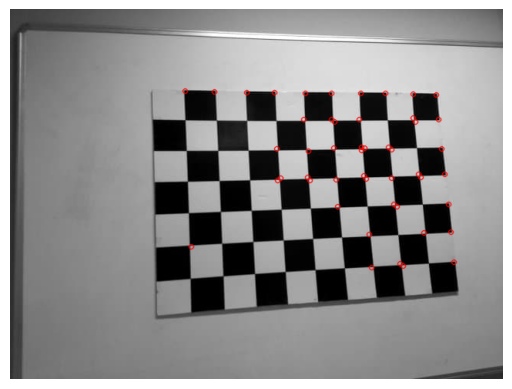

In [ ]:
#4 filter 함수를 이용하여 특징점 응답값에 따른 필터링
kp2 = list(filter(lambda x:x.response > 100, kp))
print('len(kp2)=' , len(kp2))
cv2.drawKeypoints(gray, kp2, dst, color = (255,0,0))

plt.imshow(dst)
plt.axis('off')
plt.show()

### 거리오차가 임의의 값보다 작은 특징점 삭제

len(kp3)= 38


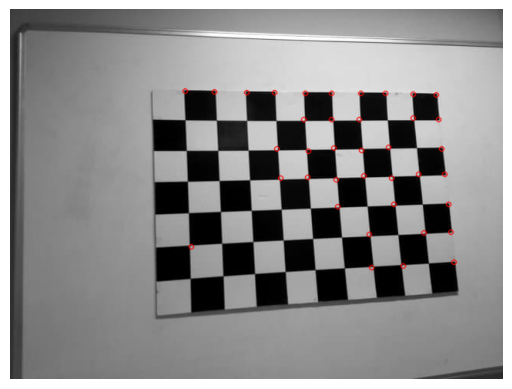

In [ ]:
#5
def distance(f1, f2):
  x1, y1 = f1.pt
  x2, y2 = f2.pt
  return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def filteringByDistance(kp, disE = 0.5):
  size = len(kp)
  mask =  np.arange(1, size + 1).astype(np.bool_) #all True

  #특징점 좌표 중 거리 오차가 작은 특징점 삭제(계속 비교해서 disE보다 작으면 삭제)

  for i, f1 in enumerate(kp):
    if not mask[i]: #mask[i] is False 이면
      continue
    else: #mask[i] is True 이면
      for j, f2 in enumerate(kp):
        if i == j:
          continue
        if distance(f1, f2) < disE:
          mask[j] = False
  np_kp = np.array(kp)

  #불리언 인덱싱 mask[i] 가 False이면 np_kp[i]를 제거한다.
  return list(np_kp[mask])

kp3 = filteringByDistance(kp2, 30)
print('len(kp3)=' , len(kp3))
dst3 = cv2.drawKeypoints(gray, kp3, None, color = (255,0,0))

plt.imshow(dst3)
plt.axis('off')
plt.show()

# 2. MSER 특징 검출


## MSER 특징 검출기

* `MSER (Maximally Stable Extremal Regions)` 특징 검출은 이미지 내의 특정한 형태의 영역을 찾는 데 사용되는 알고리즘입니다.

* 이 알고리즘은 흑백 이미지에서 일정한 밝기 또는 어두운 영역이 어떻게 변하는지를 추적하여, `안정적으로 변하지 않는 부분들을 찾아냅니다`.

## MSER 특징 검출의 원리

* `Extremal Region 정의`: Extremal Region은 그 내부의 모든 픽셀이 해당 영역의 경계에 있는 픽셀들보다 더 밝거나 더 어두운 영역입니다.
    
* `Region Growing`: 초기 값에서 시작하여 점진적으로 밝기가 증가하거나 감소하는 픽셀들을 포함시키며 영역을 넓혀가는 과정을 반복합니다.
    
* `Stability 평가`: 각 단계에서 영역이 얼마나 안정적인지를 평가합니다.  
    
* `MSER 검출`: 안정적인 영역들을 모두 찾아내고, 이들을 특징으로 사용합니다. 이 때, 영역의 크기 변화가 특정 임계값 (_delta) 이하로 안정적인 경우를 검출합니다.

## MSER의 특징

* 불변성: MSER 특징은 회전, 스케일 변화, 밝기 변화에 대해 강인합니다.

* 다양한 형태 검출: 다른 특징 검출기와 달리 MSER는 다양한 크기와 형태의 영역을 검출할 수 있습니다.

## MSER의 응용 분야

* `문자 인식`: 자연 이미지에서 텍스트 영역을 검출하는 데 사용됩니다.

* `물체 인식`: 물체의 일부분을 안정적으로 검출하여 물체 인식의 기초로 사용할 수 있습니다.

* `이미지 정합`: 두 이미지 간의 대응점(매칭 포인트)을 찾는 데 유용합니다.




### OpenCV를 이용한 MSER 특징 검출

1. MSER 특징 검출기 객체 생성 `create()`

  - 매개변수

    * `_delta`: 안정적인 그레이 레벨의 단계의 간격. 예를 들어, _delta = 10이라면 밝기 값이 10단계 차이 나는 경우에만 새로운 영역으로 인식됩니다. (기본값: 5)

    * `_min_area`: 검출할 수 있는 최소 영역의 크기. 이 값보다 작은 영역은 무시됩니다. (기본값: 60)

    * `_max_area`: 검출할 수 있는 최대 영역의 크기. 이 값보다 큰 영역은 무시됩니다. (기본값: 14400)

    * `_max_variation`: 안정적인 영역의 최대 변동률. 이 값이 클수록 더 많은 변동을 허용합니다. (기본값: 0.25)

    * `_min_diversity`: 영역 분할의 최소 다양성. 이 값이 작을수록 더 많은 세부 영역을 검출합니다. (기본값: 0.2)

    * `_max_evolution`: 영역을 확장하는 최대 단계 수. 이 값이 클수록 더 많은 단계가 허용됩니다. (기본값: 200)

    * `_area_threshold`: 영역의 최대 변화 비율. 영역 변화 비율이 이 값을 넘어서면 더 이상 확장하지 않음 . (기본값: 1.01)

    * `_min_margin`: 경계 마진의 최소값입니다. 이 값이 클수록 더 넓은 경계를 가지는 영역을 검출합니다. (기본값: 0.003)

    * `_edge_blur_size`: 엣지 블러 크기입니다. 이미지 엣지의 블러 처리를 통해 노이즈를 줄일 수 있습니다. ( 기본값: 5)

2. 영역 중심점 검출 `detect()` -> KeyPoint 반환

3. 특징 영역 검출 `detectRegions()` -> msers, bboxes
  * `msers` : (영역 개수 * 영역 내부 픽셀 수 * 좌표 ) 로 구성된 3차원 리스트
  * `bboxes` : (영역 개수 * 사각형 좌표) 로 구성된 2차원 리스트


len(kp)= 438


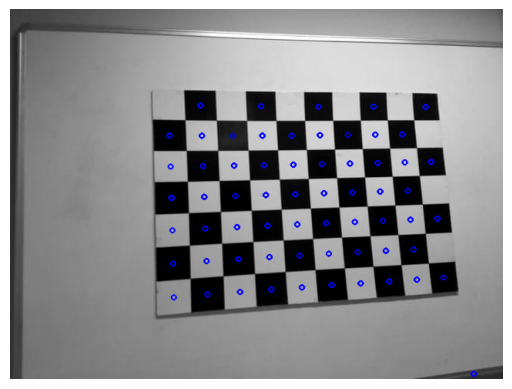

In [ ]:
src = cv2.imread('/content/drive/MyDrive/Image/chessboard.jpg의 사본')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

#1 MSER 객체 생성
mser = cv2.MSER_create(15)

#2 특징점 리스트 keypoints를 검출
kp = mser.detect(gray, None)
print('len(kp)=' , len(kp))

#3 특징점 그리기
dst = cv2.drawKeypoints(gray, kp, None, color = (0,0,255))

plt.imshow(dst)
plt.axis('off')
plt.show()

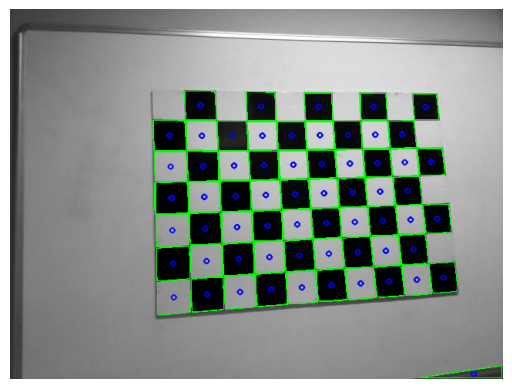

In [ ]:
dst2 = dst.copy()
regions, bboxes = mser.detectRegions(gray)

hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(dst2, hulls, 1, (0, 255, 0))

plt.imshow(dst2)
plt.axis('off')
plt.show()

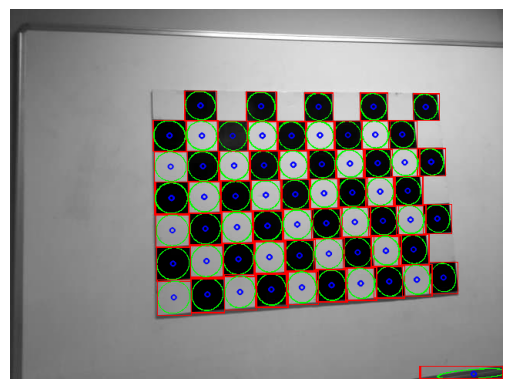

In [ ]:
dst3 = dst.copy()
for i, pts in enumerate(regions):
  box = cv2.fitEllipse(pts)
  cv2.ellipse(dst3, box, (0,255,0), 1)
  x, y, w, h = bboxes[i]
  cv2.rectangle(dst3, (x,y), (x+w, y+h), (255,0,0), 1)

plt.imshow(dst3)
plt.axis('off')
plt.show()

# 3. SimpleBlobDetector 특징 검출

## SimpleBlobDetector 특징 검출기

* SimpleBlobDetector는 이미지에서 `BlOB`(Binary Large OBject)이라고 하는 특수한 형태의 패턴을 검출하는 데 사용되는 특징 검출기입니다.

* `BLOB`은 이미지에서 일정한 크기와 모양을 가지며, 주변 픽셀과 비교해 뚜렷한 차이를 보이는 영역입니다.

## SimpleBlobDetector 특징 검출 원리

1. `이진화(Binarization) 전처리`

  * 임계값 범위 `[minThershold, maxThreshold]`에서 간격 `thresholdStep`을 적용해서 이진 영상 생성하고,` cv2.findContours()로 윤곽선을 검출`한 후 `중심점을 계산`합니다.

2. Blob 검출:
중심점 사이의 최소 간격 `minDisBetweenBlobs`에 의해 인접한 중심점을 그룹으로 분류하고 중심점의 평균을 다시 계산하여 특징점으로 합니다.

3. 주요 매개변수

  * `minThreshold`: 검출할 블롭의 최소 밝기 값입니다. 이 값보다 밝은 픽셀만 블롭으로 인식됩니다.

  * `maxThreshold`: 검출할 블롭의 최대 밝기 값입니다. 이 값보다 밝은 픽셀은 블롭으로 인식되지 않습니다.

  * `minArea`: 블롭의 최소 면적입니다. 이 값보다 작은 블롭은 무시됩니다.

  * `maxArea`: 블롭의 최대 면적입니다. 이 값보다 큰 블롭은 무시됩니다.

  * `minCircularity`: 블롭의 원형 정도입니다. 1에 가까울수록 원형에 가까운 블롭을 검출합니다.

  * `minConvexity`: 블롭의 볼록성입니다. 1에 가까울수록 더 볼록한 블롭을 검출합니다.

  * `minInertiaRatio`: 블롭의 관성 비율입니다. 1에 가까울수록 회전이 적은 블롭을 검출합니다.

### SimpleBlobDetector 원리에 따라 코드 열어보기

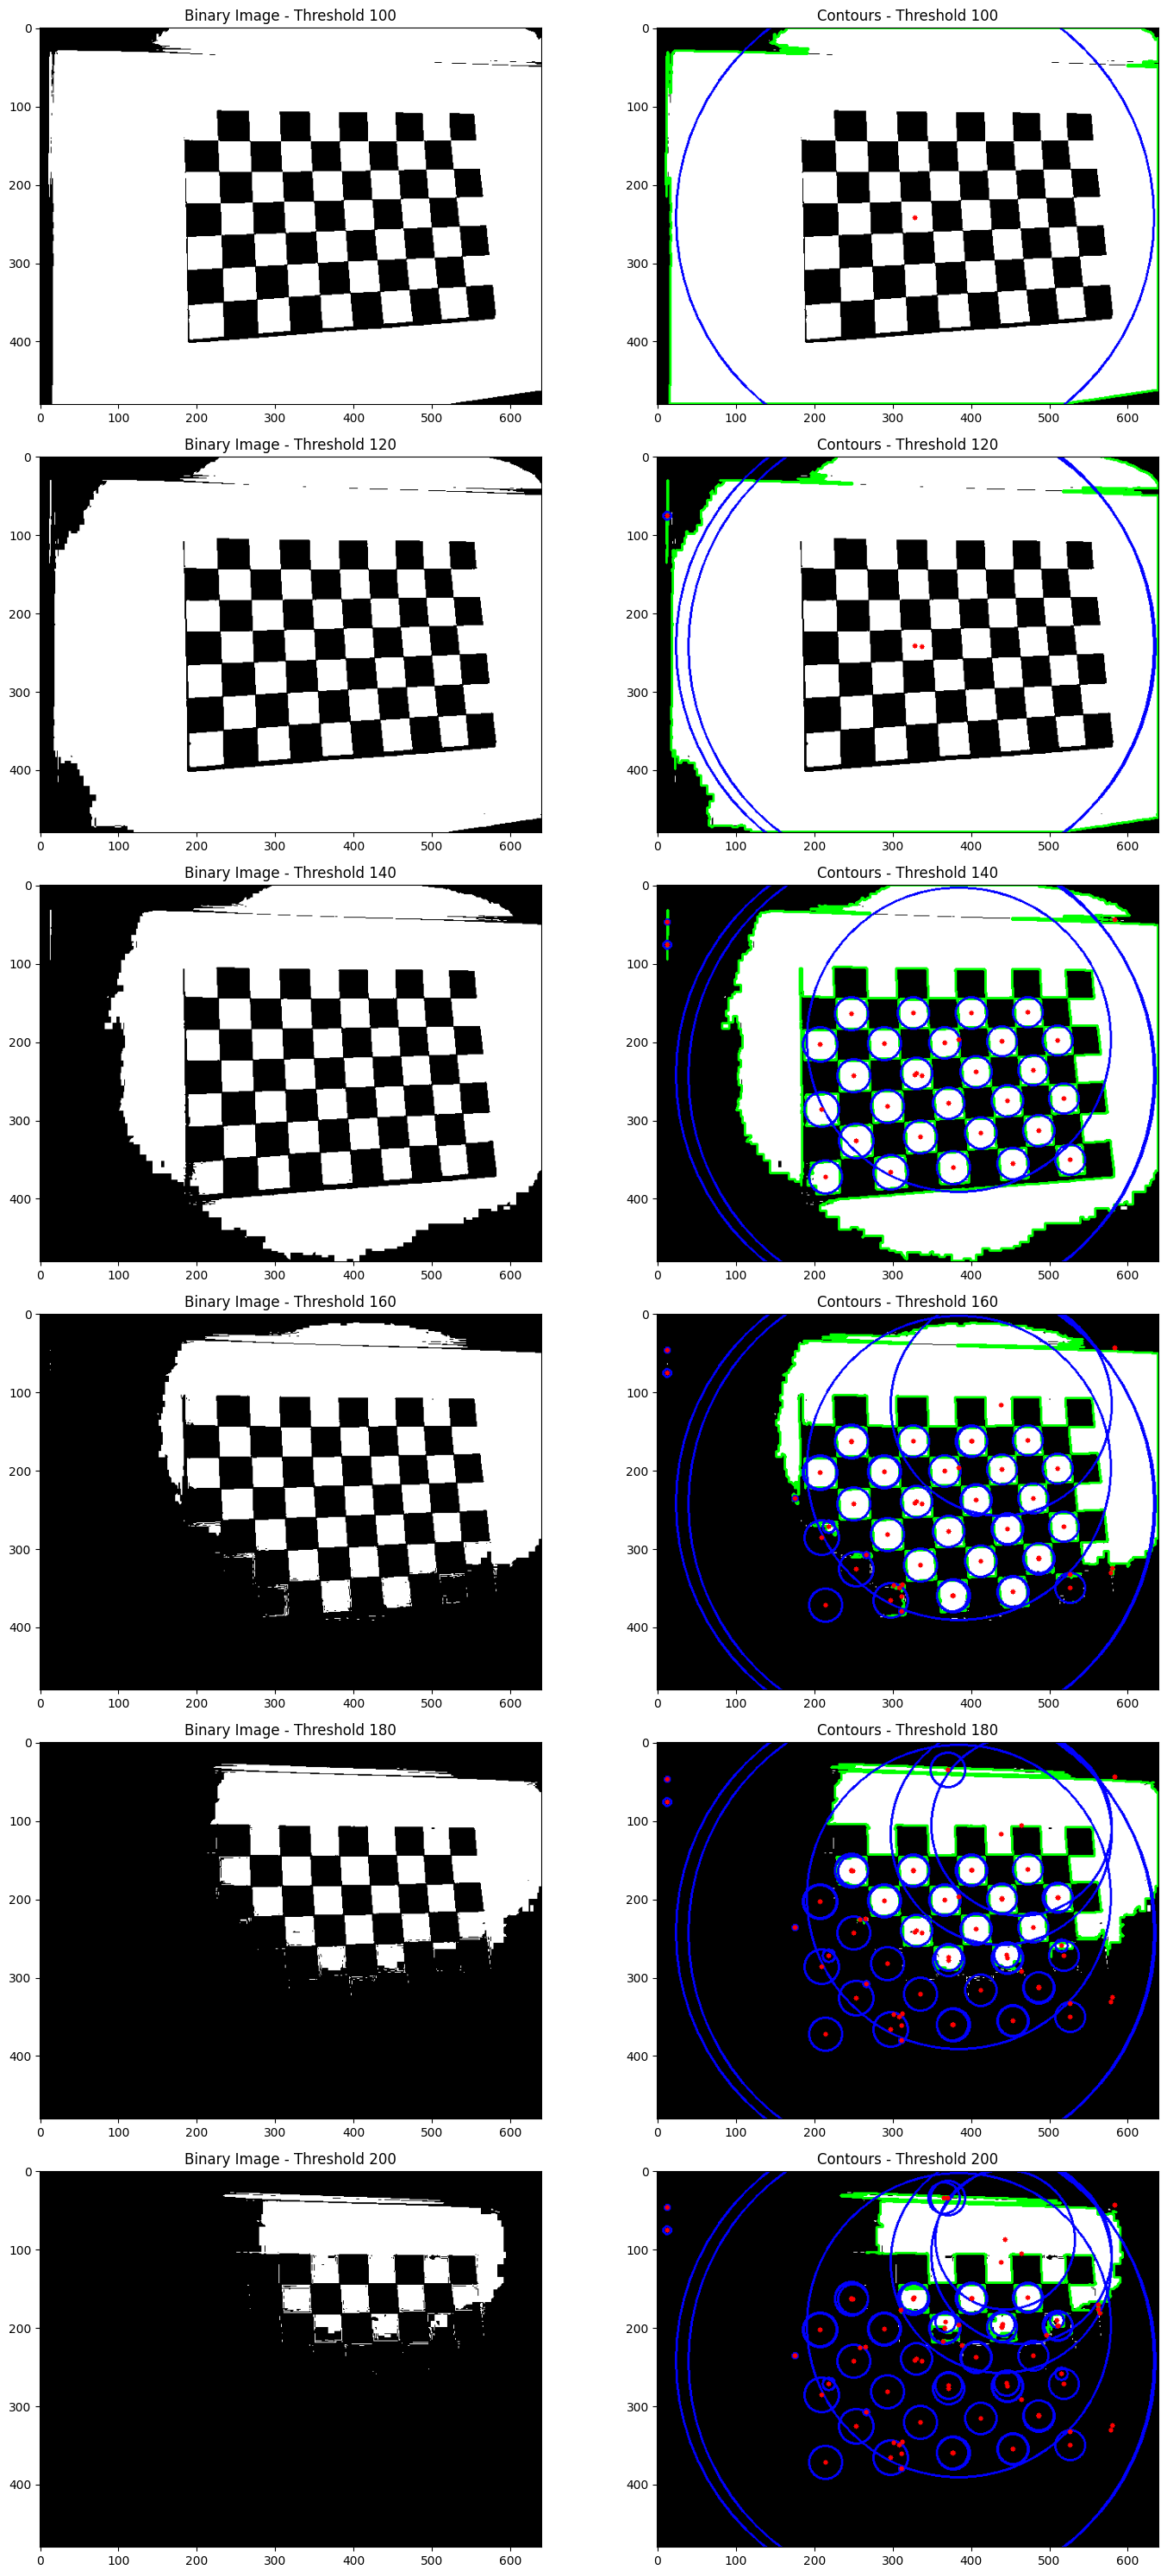

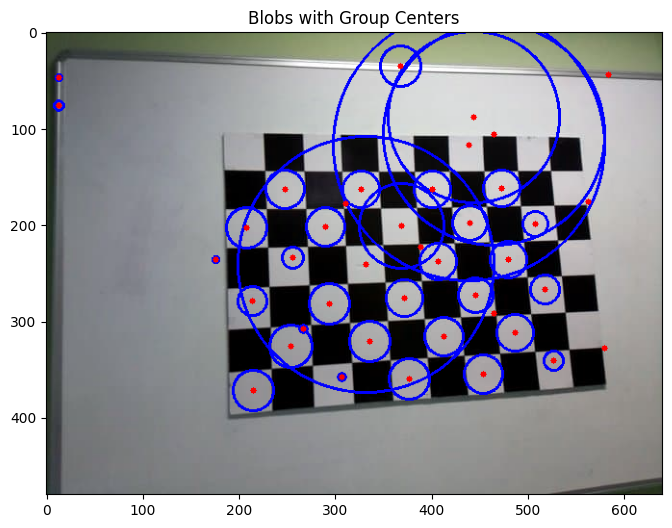

In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

def detect_blobs_and_compute_radius(image, min_threshold, max_threshold, threshold_step):
    radii = []
    centers = []
    binary_images = []

    # 이미지에 대한 subplot 준비
    num_thresholds = (max_threshold - min_threshold) // threshold_step + 1
    plt.figure(figsize=(15, 5 * num_thresholds))

    # 이진화 및 컨투어 검출 단계
    for i, threshold in enumerate(range(min_threshold, max_threshold + 1, threshold_step)):
        # 이진화
        _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
        binary_images.append(binary_image)

        # 컨투어 검출
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 5:  # 충분한 포인트 수가 있는 경우
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    area = cv2.contourArea(contour)
                    radius = np.sqrt(area / np.pi)

                    centers.append((cx, cy))
                    radii.append(radius)

        # 원본 이미지와 이진화 이미지 복사
        display_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

        # 서브플롯에 이진화 이미지 및 컨투어 그리기
        plt.subplot(num_thresholds, 2, i * 2 + 1)
        plt.title(f'Binary Image - Threshold {threshold}')
        plt.imshow(display_image)

        # 컨투어 그리기
        display_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        for contour in contours:
            if len(contour) >= 5:
                cv2.drawContours(display_image, [contour], -1, (0, 255, 0), 2)

         # 블롭 중심에 원 그리기
        for center, radius in zip(centers, radii):
            cv2.circle(display_image, tuple(map(int, center)), int(radius), (0, 0, 255), 2)

        # 그룹의 중심과 반지름 시각화
        for center, radius in zip(centers, radii):
            cv2.circle(display_image, tuple(map(int, center)), 3, (255, 0, 0), -1)

        plt.subplot(num_thresholds, 2, i * 2 + 2)
        plt.title(f'Contours - Threshold {threshold}')
        plt.imshow(display_image)

    plt.tight_layout()
    plt.show()

    return centers, radii


def group_centers(centers, radii, min_dist):
    centers = np.array(centers)
    grouped_centers = []
    grouped_radii = []
    used = np.zeros(len(centers), dtype=bool)

    for i in range(len(centers)):
        if not used[i]:
            group_center = np.array(centers[i])
            group_radii = [radii[i]]
            to_check = [i]
            while to_check:
                idx = to_check.pop(0)
                used[idx] = True
                for j in range(len(centers)):
                    if not used[j] and dist.euclidean(centers[idx], centers[j]) < min_dist:
                        to_check.append(j)
                        group_center += np.array(centers[j])
                        group_radii.append(radii[j])
                        used[j] = True

            group_center = tuple(group_center / len(group_radii))
            grouped_centers.append(group_center)
            grouped_radii.append(np.mean(group_radii))

    return grouped_centers, grouped_radii

def plot_blobs_with_groups(image, radii, group_centers, group_radii):
    plt.figure(figsize=(12, 6))

    plt.title('Blobs with Group Centers')
    plt.imshow(image, cmap='gray')

    # 그룹의 중심과 반지름 시각화
    for center, radius in zip(group_centers, group_radii):
        cv2.circle(image, tuple(map(int, center)), int(radius), (0, 0, 255), 2)

    # 그룹의 중심과 반지름 시각화
    for center, radius in zip(group_centers, group_radii):
        cv2.circle(image, tuple(map(int, center)), 3, (255, 0, 0), -1)

    plt.imshow(image)
    plt.show()

# 이미지 로드 및 블롭 검출
src = cv2.imread('/content/drive/MyDrive/chessboard.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

centers, radii = detect_blobs_and_compute_radius(gray, min_threshold=100, max_threshold=200, threshold_step=20)

# 블롭 그룹화
group_centers, group_radii = group_centers(centers, radii, min_dist=20)

# 결과 시각화
plot_blobs_with_groups(src.copy(), radii, group_centers, group_radii)

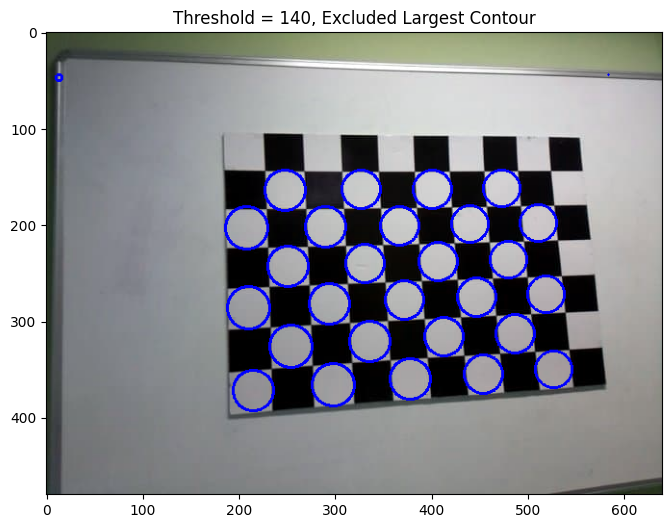

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_blobs_and_compute_radius(image, threshold):
    all_centers = []
    all_radii = []

    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 최대 아크 길이 컨투어 찾기
    max_contour = max(contours, key= lambda cnt : cv2.arcLength(cnt, closed = True), default=None)

    for contour in contours:
      if contour is max_contour:
         continue  # 최대 아크 길이 컨투어는 제외

      if len(contour) >= 5:  # 충분한 포인트 수가 있는 경우
          M = cv2.moments(contour)
          if M["m00"] != 0:
              cx = int(M["m10"] / M["m00"])
              cy = int(M["m01"] / M["m00"])
              area = cv2.contourArea(contour)
              radius = np.sqrt(area / np.pi)

              all_centers.append((cx, cy))
              all_radii.append(radius)

    return all_centers, all_radii

def plot_blobs_with_circles(image, centers, radii):
    plt.figure(figsize=(12, 6))

    plt.title('Threshold = 140, Excluded Largest Contour')
    plt.imshow(image, cmap='gray')

    for center, radius in zip(centers, radii):
        cv2.circle(image, tuple(map(int, center)), int(radius), (0, 0, 255), 2)

    plt.imshow(image)
    plt.show()

# 이미지 로드 및 블롭 검출
src = cv2.imread('/content/drive/MyDrive/chessboard.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 블롭 검출 및 반지름 계산 (가장 긴 컨투어 제외)
centers, radii = detect_blobs_and_compute_radius(gray, threshold=140)

# 결과 시각화
plot_blobs_with_circles(src.copy(), centers, radii)


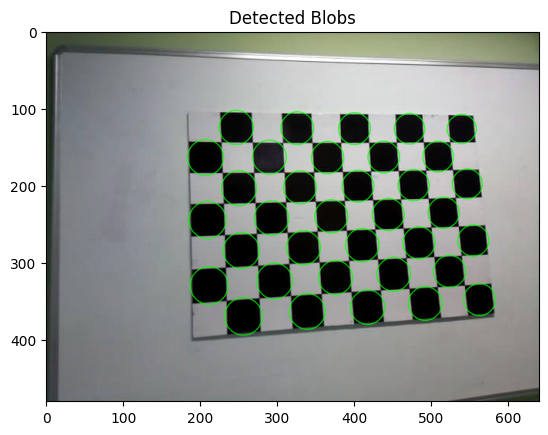

In [ ]:
# Blob detector 설정
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.thresholdStep = 10
params.minArea = 30
params.maxArea = 5000
params.minCircularity = 0.5
params.maxCircularity = 1.0
params.minConvexity = 0.8
params.minInertiaRatio = 0.1

detector = cv2.SimpleBlobDetector.create(params)

# 이미지 로드 및 블롭 검출
src = cv2.imread('/content/drive/MyDrive/chessboard.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
keypoints = detector.detect(gray)

# 시각화
output = cv2.drawKeypoints(src, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output)
plt.title('Detected Blobs')
plt.show()


# 4. GFTTDetector 특징 검출

## GFTT(Good Features to Track) Detector 특징 검출기

* 내부에서 `cv2.goodFeaturesToTrack()`을 사용하여 특징을 검출한다.

### GFTT 특징 검출의 주요 개념

* `특징점 추출`: GFTT는 cv2.cornerHarris() 또는 cv2.cornerMinEigenVal()로 특징점을 검출합니다.

* `스코어 기반 선택`: 각 검출된 특징점에는 중요도 점수(코너 스코어)가 할당됩니다. 이 스코어는 특징점이 얼마나 중요한지를 나타냅니다.


### GFTT 특징 검출 원리

1. Harris 코너 검출
  * GFTT 알고리즘은 Harris 코너 검출 방법을 기반으로 합니다. Harris 코너 검출기는 이미지에서 코너를 찾기 위해 코너 응답 함수를 사용합니다.

2. Eigenvalue 분석
  * 코너 응답 함수의 결과는 일반적으로 두 개의 eigenvalue를 갖는 2D 이미지의 행렬로 나타납니다. 코너가 감지되기 위해서는 이 두 eigenvalue가 모두 크고 비슷해야 합니다.

3. 임계값
  * 위의 두 방식으로 계산한 코너점 측정값 중에서 `최대값(maxQuality)와 qualityLevel을 곱한 값을 임계값으로 지정`합니다.

### GFTTDetector.create() 인수

* `maxCorners`: 검출할 최대 특징점 수를 지정합니다. 설정된 수를 초과할 경우 가장 중요한 특징점만 반환됩니다.

* `qualityLevel`: 검출할 특징점의 품질을 결정합니다. 값이 클수록 더 중요한(즉, 품질이 높은) 특징점을 검출합니다. 이 값은 0과 1 사이의 실수로 설정하며, 품질 수준을 기준으로 검출된 점의 비율을 의미합니다.

* `minDistance`: 특징점 사이의 최소 거리입니다. 이 값보다 가까운 특징점들은 중복된 것으로 간주되어 하나로 그룹화됩니다.

* `blockSize`: 코너 응답 계산을 위한 블록의 크기를 정의합니다. 일반적으로 3, 5, 7 등의 값을 사용하며, 블록의 크기는 코너 응답을 계산할 영역을 설정합니다.

* `useHarrisDetector`: Harris 코너 검출기를 사용할지 여부를 결정합니다. 기본값은 False이며, True로 설정하면 Harris 코너 검출 방식이 사용됩니다.

* `k`: Harris 검출기에 사용되는 계수 k입니다. Harris 코너 응답을 계산하는 데 사용되며, 0.04에서 0.06 사이의 값을 사용합니다.

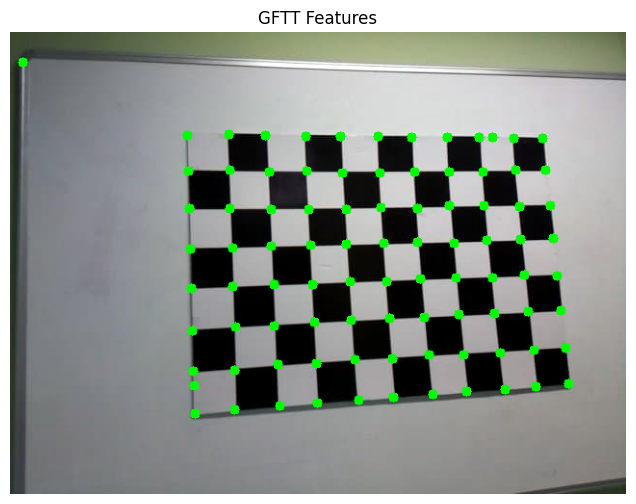

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_gftt_features(image, max_corners=100, quality_level=0.01, min_distance=10, block_size=3):
    # GFTT Detector 객체 생성
    gftt = cv2.GFTTDetector.create(maxCorners=max_corners,
                                   qualityLevel=quality_level,
                                   minDistance=min_distance,
                                   blockSize=block_size,
                                   useHarrisDetector=False,  # Harris 검출기 사용 여부
                                   k=0.04)  # Harris 검출기 계수

    # 특징점 검출
    points = gftt.detect(image, None)

    return points

def draw_keypoints(image, keypoints):
    # 이미지를 복사하여 원본을 유지
    image_with_keypoints = image.copy()

    # 특징점을 이미지에 그림
    for point in keypoints:
        x, y = point.pt
        cv2.circle(image_with_keypoints, (int(x), int(y)), 5, (0, 255, 0), -1)

    return image_with_keypoints

# 이미지 로드
# 이미지 로드 및 블롭 검출
src = cv2.imread('/content/drive/MyDrive/chessboard.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# GFTT 특징점 검출
keypoints = detect_gftt_features(gray, max_corners=100, quality_level=0.01, min_distance=10, block_size=3)

# 특징점 시각화
image_with_keypoints = draw_keypoints(src, keypoints)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.title('GFTT Features')
plt.imshow(image_with_keypoints)
plt.axis('off')  # 축을 숨깁니다.
plt.show()


# 5. ORB 특징 검출 및 디스크립터

< 다중 스케일에 대한 특징점 추출>

따라서 ORB에서는 먼저 다중 스케일에 대한 특징점 추출을 위해서 멀티 스케일 이미지 피라미드 (Multiscale image pyramid)를 사용합니다.

아래와 같이 각각의 피라미드의 구성요소는 이전 크기에 대해 축소된 크기의 영상입니다.

이를 통해 여러 크기에 대한 특징점을 미리 추출함으로써 ORB는 부분적으로 크기 불변성을 가질 수 있습니다.

# 6. BRISK 특징 검출 및 디스크립터

# 7. KAZE, AKAZE 특징 검출 및 디스크립터

# 8. SIFT 특징 검출 및 디스크립터

## SIFT 알고리즘이란?

* SIFT (Scale-Invariant Feature Transform)은 `이미지의 크기와 회전에 불변`하는 특징을 추출하는 알고리즘입니다.

* 서로 다른 두 이미지에서 SIFT 특징을 각각 추출한 다음에 서로 가장 비슷한 특징끼리 매칭해주면 두 이미지에서 대응되는 부분을 찾을 수 있다는 것이 기본 원리입니다.



## Harris Corner의 Invariance & covariance

### 불변성과 공변성

1. 불변성(Invariance)

    * 광도 변환에 상관없이 동일한 코너가 검출되어야 함.


2. 공변성(Covariance)

    * 기하학적 변환에 상관없이 동일한 코너가 검출되어야 함

### Harris Corner의 불변성과 공변성

1. **Affine intensity change** (광도의 선형적 변환)
$$
I = aI + b
$$

    * 미분 연산만이 수행된 경우 `b`에 대해서는 불변성을 가지나, `a`에 대해서는 불변성을 가지지 않음

    * 다시말해, `intensity shift에 대해서는 불변성`을, `intensity scaling에 대해서는 불변성을 가지지 않음`.

2. Image translation & rotation

    * `이미지 이동에 대해서 공변성을 가짐`.

    * 이미지 회전의 경우 고유 값은 그대로이며 고유 벡터의 방향만 변화하므로 `회전에 대해서 공변성을 가짐`.

3. **Scaling**
    
    * `동일한 응답값을 갖는 영상 패치크기를 각각 찾아 매칭시키는 것은 연산량이 매우 커진다`.

    * 또한 `특정 영상 간에 의존적인 결과`를 나타내므로 다양한 영상간의 특징점 매칭을 하기 위해 또 다른 연산이 수행되어야 한다.

    * 영상마다 한 번의 특징 검출로 다른 영상과 매칭할 수 있는 방법이 필요하다.

Original Center: (112, 112)
Downsampled Center: (56, 56)


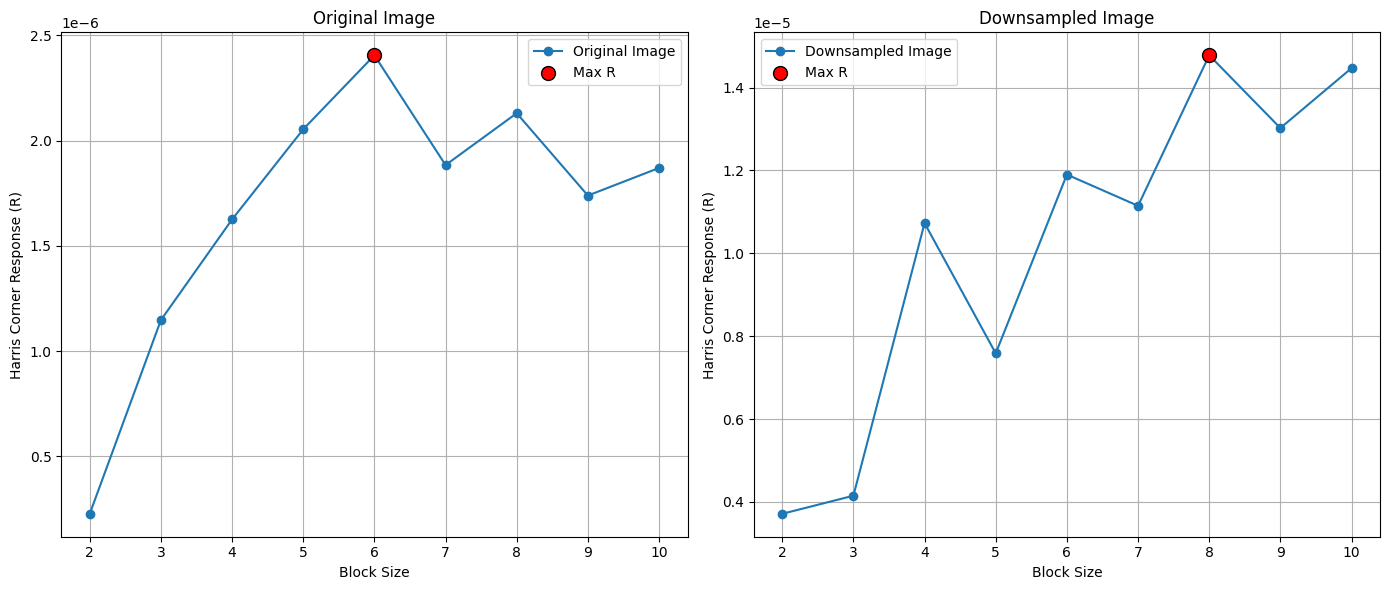

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 불러오기
image_path = '/content/drive/MyDrive/Image/low_pixel_image.jfif'  # 이미지 경로
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 순서를 사용하므로 RGB로 변환

# 2. 다운샘플링
downsampled_image = cv2.pyrDown(image_rgb)  # 2배로 다운샘플링 (가로, 세로 모두 절반)

# 3. 좌표 설정 및 변환
height, width = image_rgb.shape[:2]
original_center = (width // 2, height // 2)  # 원본 이미지에서의 좌표 (예: 중심 좌표)
downsampled_center = (original_center[0] // 2, original_center[1] // 2)  # 다운샘플링 후의 좌표

# 결과 출력
print("Original Center:", original_center)
print("Downsampled Center:", downsampled_center)

# 4. Harris Corner 응답 계산 함수
def harris_response_at_point(image, point, blockSize, ksize=3, k=0.04):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    R_map = cv2.cornerHarris(gray, blockSize, ksize, k)
    R_value = R_map[point[1], point[0]]  # 주어진 좌표의 Harris 응답값 R을 추출
    return R_value

# 5. blockSize를 변화시키며 Harris 응답 계산
block_sizes = range(2, 11)
R_values_original = []
R_values_downsampled = []

for blockSize in block_sizes:
    # 원본 이미지의 Harris 응답값 계산
    R_original = harris_response_at_point(image_rgb, original_center, blockSize)
    R_values_original.append(R_original)

    # 다운샘플링된 이미지의 Harris 응답값 계산
    R_downsampled = harris_response_at_point(downsampled_image, downsampled_center, blockSize)
    R_values_downsampled.append(R_downsampled)

# 6. 시각화
plt.figure(figsize=(14, 6))

# 원본 이미지에 대한 Harris 응답값 그래프
plt.subplot(1, 2, 1)
plt.plot(block_sizes, R_values_original, marker='o', label='Original Image')
plt.xlabel('Block Size')
plt.ylabel('Harris Corner Response (R)')
plt.title('Original Image')
plt.grid(True)
# 최대값 표시
max_idx_original = np.argmax(R_values_original)
plt.scatter(block_sizes[max_idx_original], R_values_original[max_idx_original],
            color='red', s=100, edgecolor='black', zorder=5, label='Max R')
plt.legend()

# 다운샘플링된 이미지에 대한 Harris 응답값 그래프
plt.subplot(1, 2, 2)
plt.plot(block_sizes, R_values_downsampled, marker='o', label='Downsampled Image')
plt.xlabel('Block Size')
plt.ylabel('Harris Corner Response (R)')
plt.title('Downsampled Image')
plt.grid(True)
# 최대값 표시
max_idx_downsampled = np.argmax(R_values_downsampled)
plt.scatter(block_sizes[max_idx_downsampled], R_values_downsampled[max_idx_downsampled],
            color='red', s=100, edgecolor='black', zorder=5, label='Max R')
plt.legend()

plt.tight_layout()
plt.show()


# 9. 디스크립터를 이용한 특징 매칭

# 10. HOG 디스크립터

# 11. 영상 스티칭